In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_og = pd.read_csv("cleaned_survey_binary_columns.csv")
df_og['sev_suicidal_thoughts'] = df_og['sev_suicidal_thoughts_clean']
time_off_mapping_binary = {'none': 0,
                           '1-5 days': 1,
                           '5-10 days': 1,
                           '10-20 days': 1,
                           'more than 20 days': 1,
                           '_missing_': np.nan}
time_off_mapping = {
    'none': 0,
    '1-5 days': 1,
    '5-10 days': 2,
    '10-20 days': 3,
    'more than 20 days': 4,
    '_missing_': np.nan
}
df_og["worst_symptoms_time_off_binary"] = df_og["worst_symptoms_time_off"].map(time_off_mapping_binary)
df_og.dropna(subset = ["worst_symptoms_time_off_binary"], how = "any", axis = 0, inplace=True)
df=df_og.drop(columns = {'sev_suicidal_thoughts_clean'})
validation_set = df.sample(100)
df = df.drop(validation_set.index)

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import make_scorer, mean_absolute_error, confusion_matrix
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler

In [8]:
# Define the mapping dictionaries
ordinal_mapping = {'none': 0, 'mild': 1, 'moderate': 2, 'severe': 3, "_missing_":np.nan,'never': 0, 'occasionally': 1, 'monthly': 2, 'weekly': 3, 'daily': 4}


In [9]:
X = df[[col for col in df.columns if col.startswith("sev")] + [col for col in df.columns if col.startswith("sev")]]
y = df["worst_symptoms_time_off_binary"]

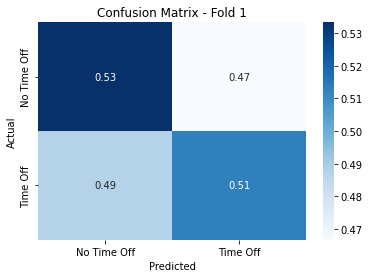

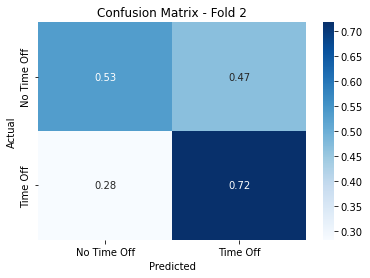

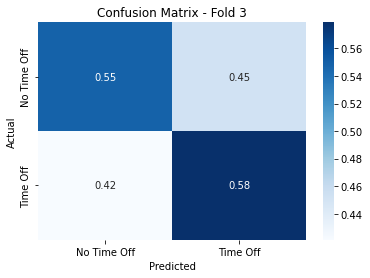

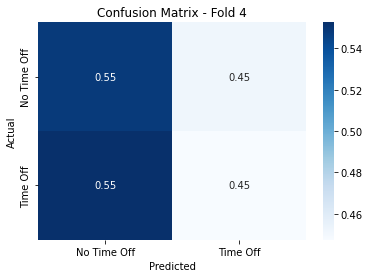

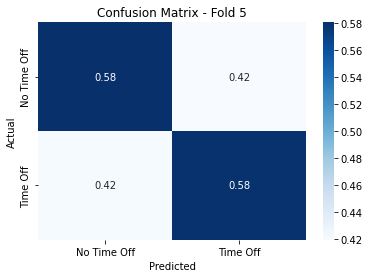

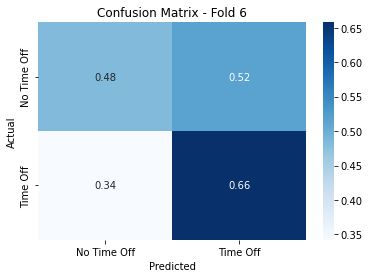

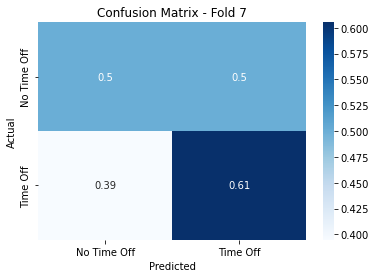

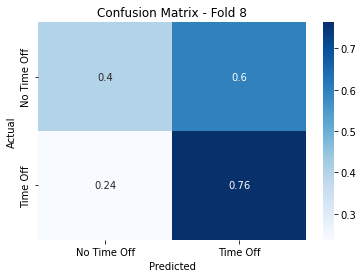

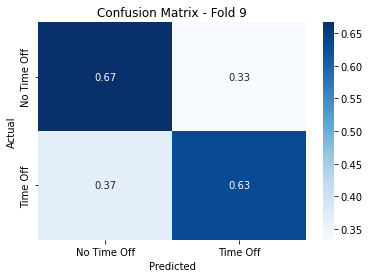

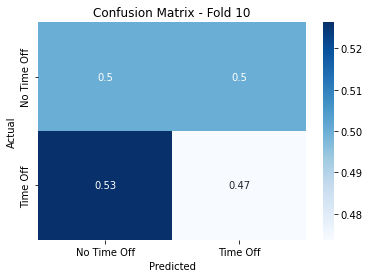

Cross-validation accuracy scores: [0.5217391304347826, 0.6376811594202898, 0.5652173913043478, 0.4927536231884058, 0.5797101449275363, 0.5797101449275363, 0.5588235294117647, 0.6029411764705882, 0.6470588235294118, 0.4852941176470588]
Mean CV accuracy score: 0.5670929241261722
Cross-validation precision scores: [0.5882352941176471, 0.6666666666666666, 0.6111111111111112, 0.5483870967741935, 0.6285714285714286, 0.6097560975609756, 0.6052631578947368, 0.6170212765957447, 0.7058823529411765, 0.5454545454545454]
Mean CV precision score: 0.6126349027688226
Cross-validation recall scores: [0.5128205128205128, 0.717948717948718, 0.5789473684210527, 0.4473684210526316, 0.5789473684210527, 0.6578947368421053, 0.6052631578947368, 0.7631578947368421, 0.631578947368421, 0.47368421052631576]
Mean CV recall score: 0.5967611336032389
Cross-validation F1 scores: [0.547945205479452, 0.691358024691358, 0.5945945945945946, 0.49275362318840576, 0.6027397260273972, 0.6329113924050632, 0.6052631578947368, 0

In [10]:
severity_weights = [0.5]*23
#[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 0.1, 0.2, 0.3]
frequency_weights = [0.5]*23
#[0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.0, 0.9, 0.8, 0.7]

symptom_cluster_mapping = {
    'strong_heart_beating': 0,
    'feeling_dizzy_faint': 0,
    'head_pressure_tightness': 0,
    'tinnitus': 0,
    'headaches': 0,
    'feeling_pins_needles': 0,
    'breathing_difficulties': 0,
    'feeling_tense_nervous': 3,
    'panic_anxiety_attacs': 3,
    'depression_interest_loss': 3,
    'suicidal_thoughts': 3,
    'crying_spells': 3,
    'irritability': 3,
    'sleeping_difficulty': 1,
    'memory_problems': 1,
    'difficulty_concentrating': 1,
    'tired_lack_energy': 1,
    'muscle_joint_pain': 1,
    'hot_flushes': 4,
    'night_sweats': 4,
    'sex_interest_loss': 2,
    'urinary_symptoms': 2,
    'vaginal_dryness': 2
}

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Define the pipeline without oversampling
pipeline = Pipeline([
    ('classifier', RandomForestClassifier())
])

# Perform cross-validation
cv_results = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
fold = 0
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Step 2: Encode severity and frequency columns
    X_train_encoded = X_train.replace(ordinal_mapping)
    X_test_encoded = X_test.replace(ordinal_mapping)

    # Step 3: Impute missing values using the mode
    imputer = SimpleImputer(strategy='most_frequent')
    X_train_imputed = imputer.fit_transform(X_train_encoded)
    X_test_imputed = imputer.transform(X_test_encoded)

    # Step 4: Combine severity and frequency columns with equal weighting
    combined_values_train = X_train_imputed[:, :len(severity_weights)]  + X_train_imputed[:, len(severity_weights):] 
    combined_values_test = X_test_imputed[:, :len(severity_weights)]  + X_test_imputed[:, len(severity_weights):]
    
    # step 5: encode the clusters and reduce dimensions of the data
    a = pd.DataFrame(combined_values_train, columns = symptom_cluster_mapping.keys())
    b = pd.DataFrame(combined_values_test, columns = symptom_cluster_mapping.keys())
    
    # Create a DataFrame with the symptom cluster mapping
    df_mapping = pd.DataFrame.from_dict(symptom_cluster_mapping, orient='index', columns=['Cluster'])
    df_weighted_suma = pd.DataFrame(index=a.index)
    df_weighted_sumb = pd.DataFrame(index=b.index)
    # Iterate over each cluster
    
    for cluster, columns in df_mapping.groupby('Cluster').groups.items():
    # Get the columns in the cluster
        cluster_columns = columns.tolist()
        # Calculate the weighted sum for the cluster
        df_weighted_suma[f'Cluster_{cluster}_Sum'] = a[cluster_columns].sum(axis=1)
        df_weighted_sumb[f'Cluster_{cluster}_Sum'] = b[cluster_columns].sum(axis=1)
        
    df_weighted_suma.columns = ["physical", "cognitive", "gyn", "mood", "meno"]
    df_weighted_sumb.columns = ["physical", "cognitive", "gyn", "mood", "meno"]
    
    clusters_train = np.array(df_weighted_suma)
    clusters_test = np.array(df_weighted_sumb)
    
    # Perform oversampling on the training data
    oversampler = RandomOverSampler(random_state=42)
    X_train_oversampled, y_train_oversampled = oversampler.fit_resample(clusters_train, y_train)

    # Fit the pipeline on the oversampled training data
    pipeline.fit(X_train_oversampled, y_train_oversampled)

    # Make predictions on the test set
    y_pred = pipeline.predict(clusters_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Store the results
    cv_results['accuracy'].append(accuracy)
    cv_results['precision'].append(precision)
    cv_results['recall'].append(recall)
    cv_results['f1'].append(f1)

    # Plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    labels = ['No Time Off', 'Time Off']
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix - Fold {fold+1}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    fold +=1

# Print the cross-validation results
print("Cross-validation accuracy scores:", cv_results['accuracy'])
print("Mean CV accuracy score:", sum(cv_results['accuracy']) / len(cv_results['accuracy']))
print("Cross-validation precision scores:", cv_results['precision'])
print("Mean CV precision score:", sum(cv_results['precision']) / len(cv_results['precision']))
print("Cross-validation recall scores:", cv_results['recall'])
print("Mean CV recall score:", sum(cv_results['recall']) / len(cv_results['recall']))
print("Cross-validation F1 scores:", cv_results['f1'])
print("Mean CV F1 score:", sum(cv_results['f1']) / len(cv_results['f1']))

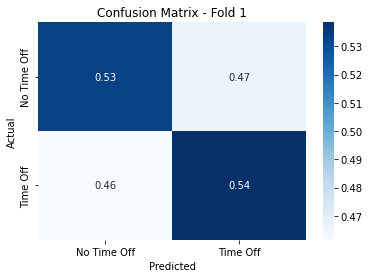

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


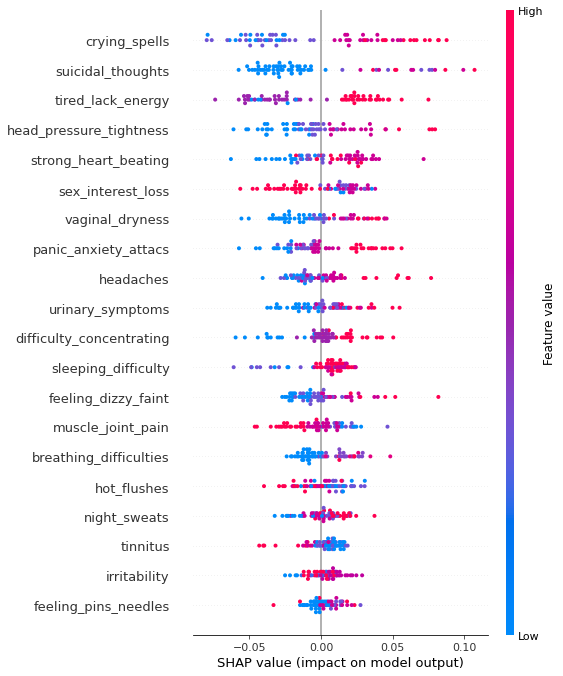

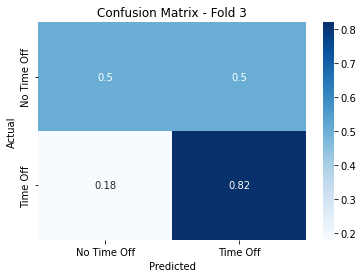

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


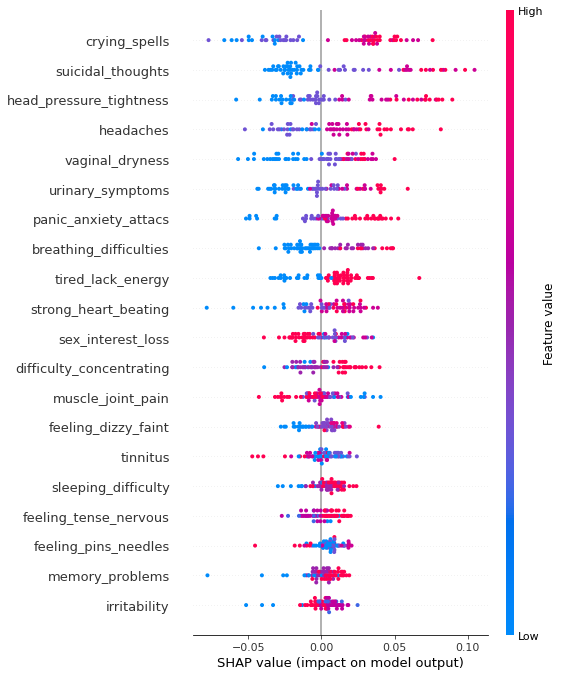

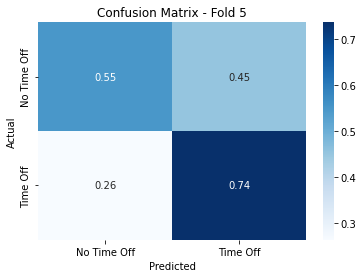

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


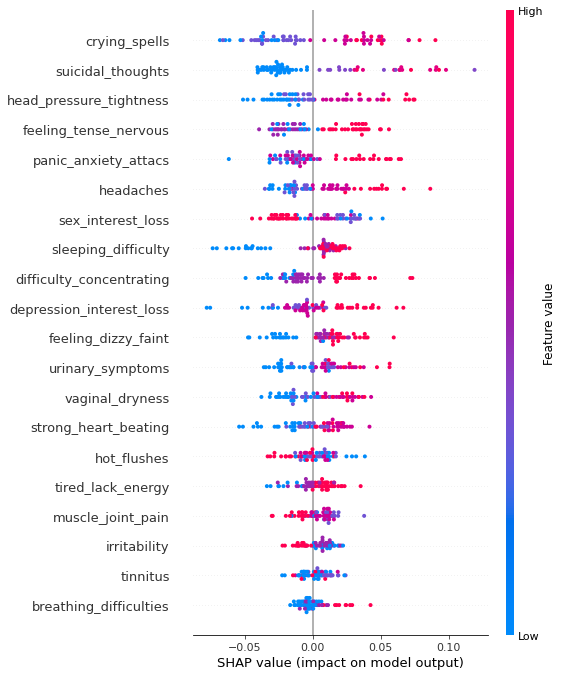

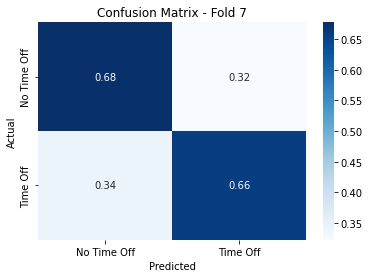

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


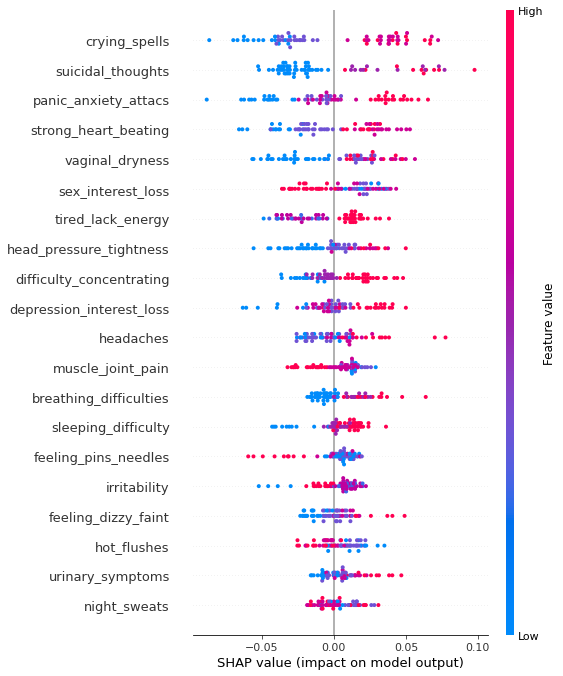

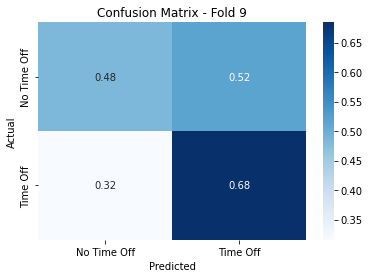

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


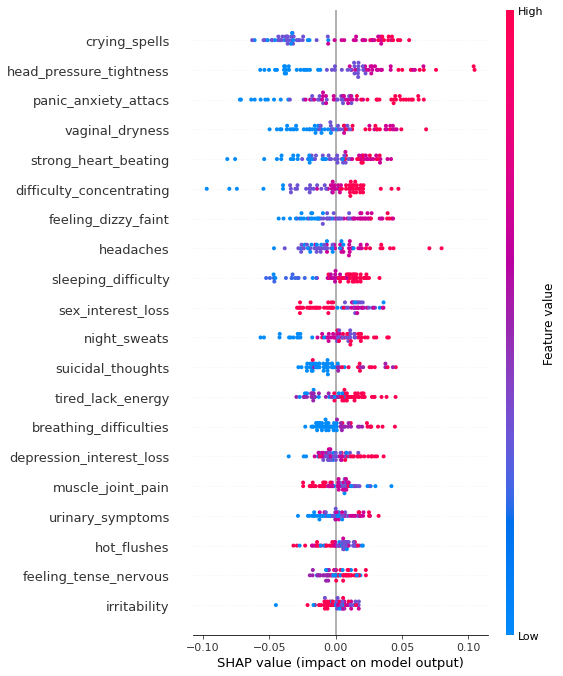

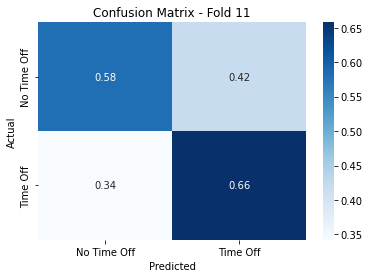

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


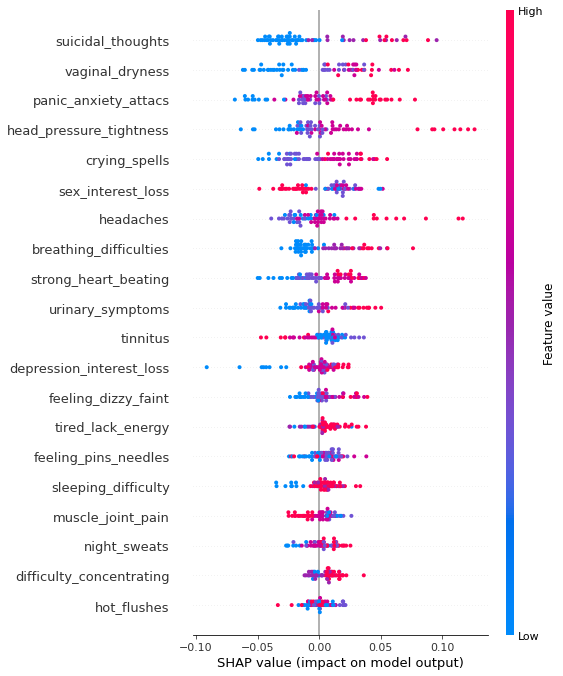

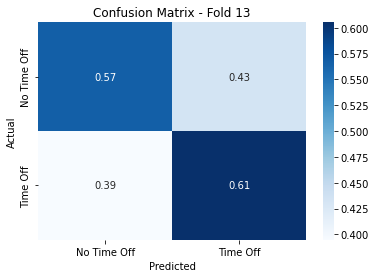

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


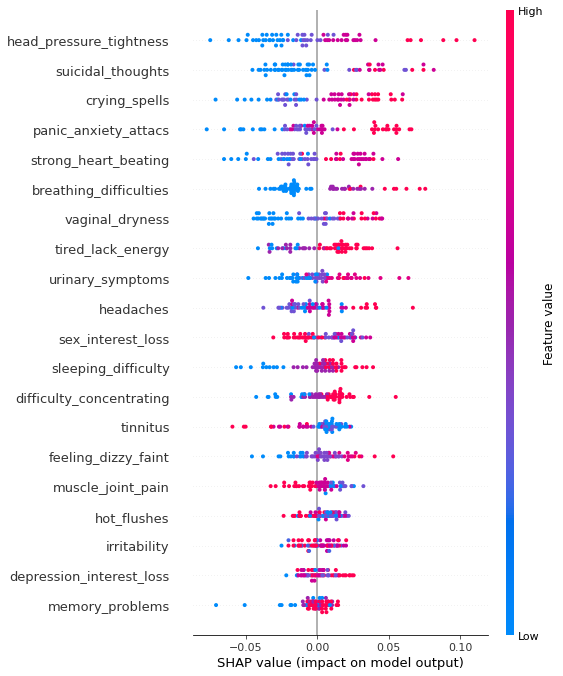

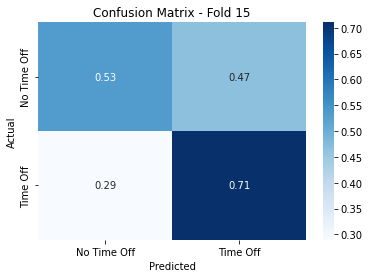

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


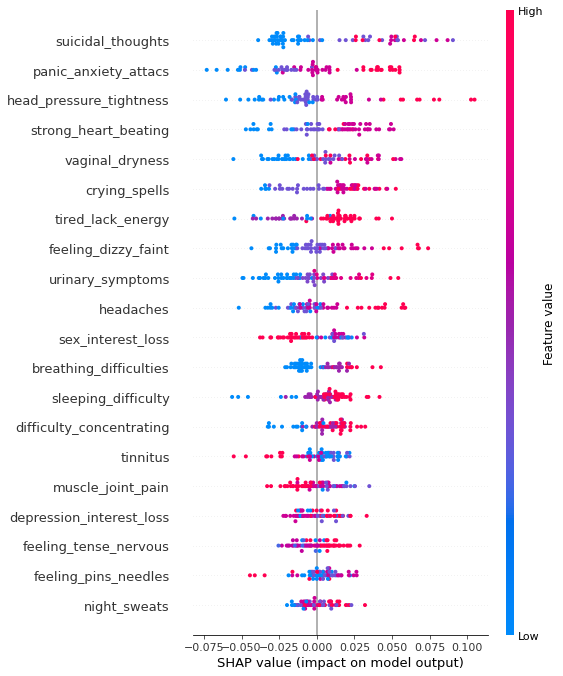

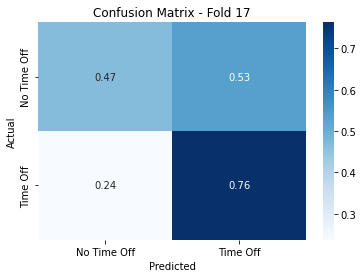

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


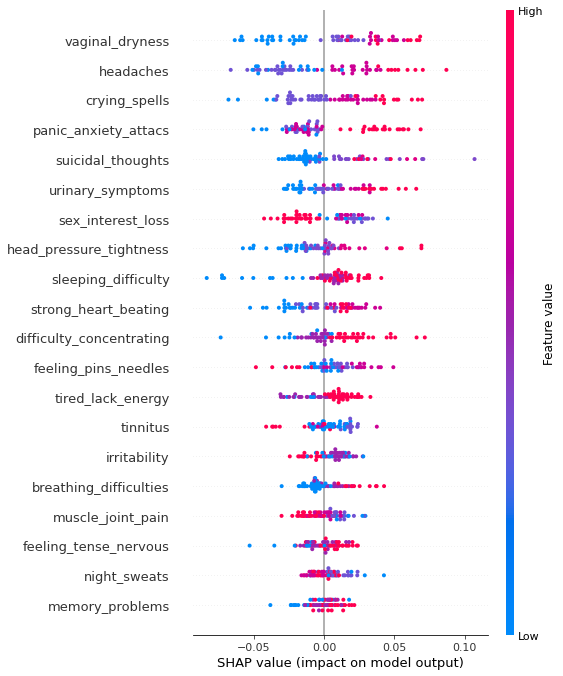

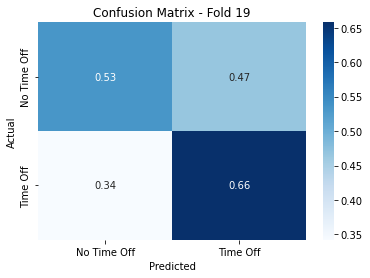

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


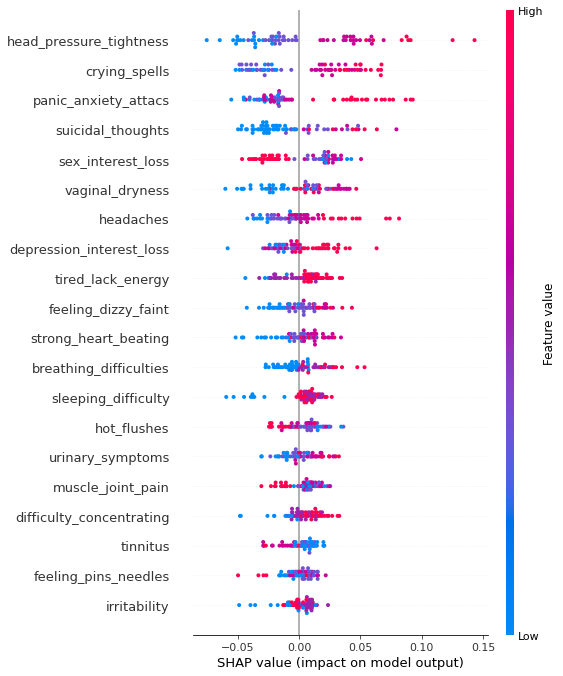

Cross-validation accuracy scores: [0.5362318840579711, 0.6811594202898551, 0.6521739130434783, 0.6666666666666666, 0.5942028985507246, 0.6231884057971014, 0.5882352941176471, 0.6323529411764706, 0.6323529411764706, 0.6029411764705882]
Mean CV accuracy score: 0.6209505541346974
Cross-validation precision scores: [0.6, 0.6808510638297872, 0.6666666666666666, 0.7142857142857143, 0.6190476190476191, 0.6578947368421053, 0.6388888888888888, 0.6585365853658537, 0.6444444444444445, 0.6410256410256411]
Mean CV precision score: 0.6521641360396722
Cross-validation recall scores: [0.5384615384615384, 0.8205128205128205, 0.7368421052631579, 0.6578947368421053, 0.6842105263157895, 0.6578947368421053, 0.6052631578947368, 0.7105263157894737, 0.7631578947368421, 0.6578947368421053]
Mean CV recall score: 0.6832658569500676
Cross-validation F1 scores: [0.5675675675675675, 0.7441860465116279, 0.7, 0.684931506849315, 0.6500000000000001, 0.6578947368421053, 0.6216216216216216, 0.6835443037974684, 0.69879518

In [109]:
import shap
from xgboost import XGBClassifier

severity_weights = [0.5]*23
#[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 0.1, 0.2, 0.3]
frequency_weights = [0.5]*23
#[0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.0, 0.9, 0.8, 0.7]

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Define the pipeline without oversampling
pipeline = Pipeline([
    ('classifier', (RandomForestClassifier()))
])

# Perform cross-validation
cv_results = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

fold = 0
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Step 2: Encode severity and frequency columns
    X_train_encoded = X_train.replace(ordinal_mapping)
    X_test_encoded = X_test.replace(ordinal_mapping)

    # Step 3: Impute missing values using the mode
    imputer = SimpleImputer(strategy='most_frequent')
    X_train_imputed = imputer.fit_transform(X_train_encoded)
    X_test_imputed = imputer.transform(X_test_encoded)

    # Step 4: Combine severity and frequency columns with equal weighting
    combined_values_train = X_train_imputed[:, :len(severity_weights)]  + X_train_imputed[:, len(severity_weights):] 
    combined_values_test = X_test_imputed[:, :len(severity_weights)]  + X_test_imputed[:, len(severity_weights):]

    # Perform oversampling on the training data
    oversampler = RandomOverSampler(random_state=42)
    X_train_oversampled, y_train_oversampled = oversampler.fit_resample(combined_values_train, y_train)

    # Fit the pipeline on the oversampled training data
    pipeline.fit(X_train_oversampled, y_train_oversampled)

    # Make predictions on the test set
    y_pred = pipeline.predict(combined_values_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Store the results
    cv_results['accuracy'].append(accuracy)
    cv_results['precision'].append(precision)
    cv_results['recall'].append(recall)
    cv_results['f1'].append(f1)

    # Plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    labels = ['No Time Off', 'Time Off']
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix - Fold {fold+1}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    fold +=1
    

    # Get the classifier from the pipeline
    classifier = pipeline.named_steps['classifier']

    # Initialize the SHAP explainer for the classifier
    explainer = shap.Explainer(classifier)

    # Explain the model predictions using SHAP for the classifier
    shap_values = explainer.shap_values(combined_values_test)

    # Plot the SHAP summary plot
    shap.summary_plot(shap_values[1], combined_values_test, feature_names=[col.replace("sev_", "") for col in X.iloc[:, :len(severity_weights)].columns])
    
    
    fold += 1
    

# Print the cross-validation results
print("Cross-validation accuracy scores:", cv_results['accuracy'])
print("Mean CV accuracy score:", sum(cv_results['accuracy']) / len(cv_results['accuracy']))
print("Cross-validation precision scores:", cv_results['precision'])
print("Mean CV precision score:", sum(cv_results['precision']) / len(cv_results['precision']))
print("Cross-validation recall scores:", cv_results['recall'])
print("Mean CV recall score:", sum(cv_results['recall']) / len(cv_results['recall']))
print("Cross-validation F1 scores:", cv_results['f1'])
print("Mean CV F1 score:", sum(cv_results['f1']) / len(cv_results['f1']))

In [104]:
# Calculate Shap values
instance = 67
choosen_instance = dict(zip([col.replace("sev_", "") for col in X.iloc[:, :len(severity_weights)].columns], combined_values_test[instance, :]))
choosen_instancedf = pd.DataFrame(choosen_instance, index = [0])

In [105]:
choosen_instancedf

,strong_heart_beating,feeling_tense_nervous,sleeping_difficulty,memory_problems,panic_anxiety_attacs,difficulty_concentrating,tired_lack_energy,depression_interest_loss,suicidal_thoughts,crying_spells,...,tinnitus,headaches,muscle_joint_pain,feeling_pins_needles,breathing_difficulties,hot_flushes,night_sweats,sex_interest_loss,urinary_symptoms,vaginal_dryness
0,4.0,6.0,4.0,6.0,6.0,6.0,4.0,6.0,4.0,6.0,...,0.0,4.0,2.0,2.0,4.0,2.0,0.0,2.0,6.0,0.0


In [106]:
shap_values = explainer.shap_values(choosen_instancedf)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instancedf)

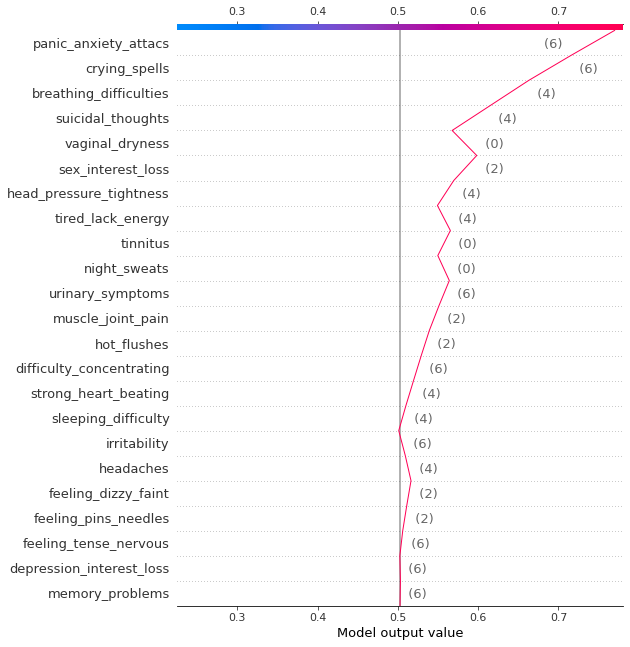

In [108]:
shap.decision_plot(explainer.expected_value[1], shap_values[1],choosen_instancedf, feature_display_range=slice(None, -31, -1))

In [37]:
combined_values_test[45, :]

array([4., 2., 4., 4., 0., 0., 6., 0., 0., 0., 2., 2., 4., 0., 4., 6., 4.,
       2., 4., 4., 6., 0., 0.])

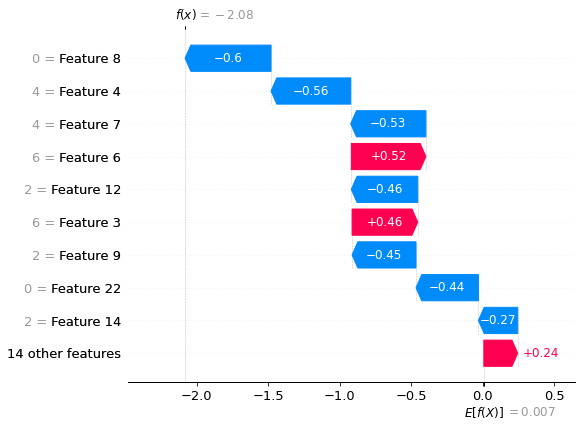

In [19]:
# compute SHAP values
# Get the classifier from the pipeline
classifier = pipeline.named_steps['classifier']

# Initialize the SHAP explainer for the classifier
explainer = shap.Explainer(classifier)
shap_values = explainer(combined_values_test)
shap.plots.waterfall(shap_values[0])

In [29]:
shap_values

.values =
array([[[-0.00429167,  0.00429167],
        [ 0.0204258 , -0.0204258 ],
        [-0.00927009,  0.00927009],
        ...,
        [-0.00578808,  0.00578808],
        [ 0.00675523, -0.00675523],
        [ 0.03593061, -0.03593061]],

       [[-0.01760502,  0.01760502],
        [ 0.00701489, -0.00701489],
        [-0.00697502,  0.00697502],
        ...,
        [ 0.02791677, -0.02791677],
        [-0.01472995,  0.01472995],
        [-0.01968191,  0.01968191]],

       [[-0.01796661,  0.01796661],
        [-0.00787566,  0.00787566],
        [-0.00841631,  0.00841631],
        ...,
        [-0.0337698 ,  0.0337698 ],
        [-0.00046127,  0.00046127],
        [-0.02526467,  0.02526467]],

       ...,

       [[-0.0039726 ,  0.0039726 ],
        [ 0.00347707, -0.00347707],
        [ 0.02324145, -0.02324145],
        ...,
        [ 0.00508415, -0.00508415],
        [-0.00428003,  0.00428003],
        [ 0.03303816, -0.03303816]],

       [[-0.01861317,  0.01861317],
        [-0.00330

In [ ]:
X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Step 2: Encode severity and frequency columns
X_train_encoded = X_train.replace(ordinal_mapping)
X_test_encoded = X_test.replace(ordinal_mapping)

# Step 3: Impute missing values using the mode
imputer = SimpleImputer(strategy='most_frequent')
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_test_imputed = imputer.transform(X_test_encoded)

# Step 4: Combine severity and frequency columns with equal weighting
combined_values_train = X_train_imputed[:, :len(severity_weights)]  + X_train_imputed[:, len(severity_weights):] 
combined_values_test = X_test_imputed[:, :len(severity_weights)]  + X_test_imputed[:, len(severity_weights):]

# Perform oversampling on the training data
oversampler = RandomOverSampler(random_state=42)
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train_imputed, y_train)

from sklearn.decomposition import PCA

n_components = 18
pca = PCA(n_components=n_components)

# Fit PCA on your ordinal data
pca.fit(X_train_oversampled)

# Transform the data to its principal components
X_pca = pca.transform(X_train_oversampled)

# Print the explained variance ratio of the selected components
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

# Create a DataFrame with the transformed data
df_pca = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(n_components)])

# Create a bar plot of the explained variance ratio
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Component')
plt.show()

In [ ]:
# Get the loadings or coefficients
loadings = pca.components_

# Access loadings for each principal component
for i, component in enumerate(loadings):
    print(f"Principal Component {i+1} Loadings:")
    for j, feature in enumerate(symptom_cluster_mapping.keys()):
        print(f"{feature}: {component[j]}")
    print()

In [ ]:
[symp.replace("sev_", "") for symp in X.columns if symp.startswith("sev_")]

In [111]:
np.std([0.5362318840579711, 0.6811594202898551, 0.6521739130434783, 0.6666666666666666, 0.5942028985507246, 0.6231884057971014, 0.5882352941176471, 0.6323529411764706, 0.6323529411764706, 0.6029411764705882])

0.0403017636729156